# Lab 2: Python and GitHub Bootcamp

ENGS 199.20  
2025-07-19

## Overview

Today we’re going to practice our lab GitHub workflow and learn/refresh
Python code for the types of analyses we’ll see in future labs. There’s
a lot of content in this lab, so I will host an extra hour session on
Tuesday so that I’m available for questions. Today’s lab is not graded
but I will provide feedback on your submission to provide guidance on
expectations for future submissions.

Today’s objectives:

1.  Become more comfortable using [numpy](https://numpy.org/) for
    efficient array-based operations
2.  Become more comfortable using [pandas](https://pandas.pydata.org/)
    for structured data analysis
3.  Create a reproducible analysis with GitHub
4.  Get some practice using Python to address a *toy* decision analysis
    problem

It’s pretty easy to find tutorials online for #1-#3 above. I thought it
would be fun to have a more applied example. I will link to reference
material and point out tips for where certain coding decisions come from
to help you engage with that type of material.

Let’s pretend you just got hired as a flood risk analyst for an
emergency management department. The city council has a budget to spend
on flood mitigation strategies before the next storm season. Your job is
to analyze two potential flood scenarios and provide actionable
recommendations.

> **Important**
>
> This tutorial is for learning coding skills. We will violate a lot of
> decision analysis principles I will teach later in the term in service
> of meeting our primary objectives for today’s lab.

## Lab Workflow

### GitHub Repository Setup

1.  Go to GitHub and create a new repository called “toy-flood-analysis”
2.  Clone the repo locally (I recommend using ssh as discussed last lab)
3.  Create the folder structure below

<!-- -->

    toy-flood-analysis/
       ├── data/
       ├── notebooks/
       ├── figures/
       └── README.md
       └── .gitignore

Your README.md should include the following structure:

    # Toy Flood Analysis

    ## Project Description
    [explain project]

    ## How to Run
    [reproducibility instructions]

Here’s an example of a GitHub repository with reproducibility
instructions:
<https://github.com/IMMM-SFA/burleyson-etal_2024_applied_energy>. You
can check out the raw markdown
[here](https://github.com/IMMM-SFA/burleyson-etal_2024_applied_energy/blob/main/Readme.md?plain=1).

Remember to regularly add, commit, and push changes to your remote
branch.

### Setting up our computing environment

Create a file called `env-lock.yml` in your project directory. Add the
following contents and save:

``` yaml
name: lab2
channels:
  - conda-forge
dependencies:
  - python
  - pandas # great for tabular data
  - numpy # great for efficient operations on large arrays
  - matplotlib # standard plotting library for python
  - nbconvert # for converting our notebook to pdf for submission
  - ipykernel # for setting up the kernel for using this env in jupyter
  - seaborn # good for exploratory data analysis and some final figures
  - jupyter 
  - conda-lock
```

Run `mamba create -f env-lock.yml`. Run `mamba activate lab2`. Set up
the kernel for the environment with
`python -m ipykernel install --user --name lab2 --display-name lab2`.

### Setting up our analysis

Create a new .ipynb file in the `notebooks/` subdirectory. In the first
cell, let’s import our tools for the analysis.

In [1]:
# Core numerical computing
import numpy as np

# Data manipulation and analysis
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Building our toy problem

Our city is fake, so we have to build it. We will create a fake digital
elevation grid, a fake built environment, and fake flood scenarios.

Below, we define a
[function](https://docs.python.org/3/tutorial/controlflow.html#defining-functions)
to create an elevation grid for the city. We use `numpy` because it’s a
great tool for setting up our 2d array. We will use a
[meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)
to set up our grid.

Please read the comments and test out any lines of code you want to
understand better. I encourage you to reference the `numpy`
documentation to read about any functions you’re seeing for the first
time.

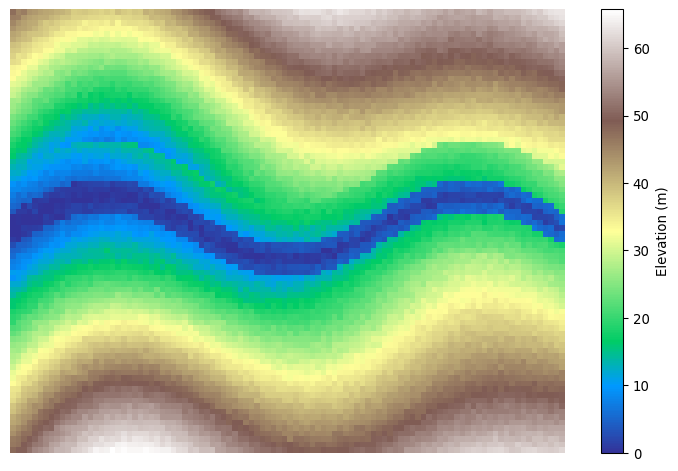

In [2]:
def create_terrain(width=100, height=80):
    """
    Create an elevation grid using numpy meshgrid

    Key features:
        - Rivers are the lowest elevations (like real topography)
        - Land slopes toward rivers creating natural drainage
        - Floodplains are flat areas adjacent to rivers
        - Higher elevations are away from water

    Keyword arguments:
    width -- the number of columns in our elevation grid
    height -- the number of rows in our elevation grid
    """
    # Set seed for reproducible terrain
    rng = np.random.default_rng(42)

    # Create coordinate grids
    x = np.linspace(0, width/10, width)
    y = np.linspace(0, height/10, height)
    X, Y = np.meshgrid(x, y)

    # Define river path (straight east-west through middle)
    river_center_y = height // 2
    
    # Create a slightly meandering river path
    river_path = river_center_y + 6 * np.sin(np.linspace(0, 3*np.pi, width))
    
    # Calculate distance from each point to the river
    # Elevation increases with distance from water
    distance_to_river = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            river_y_at_x = river_path[j]
            distance_to_river[i, j] = abs(i - river_y_at_x)
    
    # Create elevation based on distance to water
    # Start with river at elevation 0, then build up from there
    
    # Base elevation: increases as you move away from river
    elevation = distance_to_river * 1.2  # 1.2m rise per grid cell from river
    
    # Add gentle regional slope (slightly higher in the east)
    elevation += X * 1.5
    
    # Add some rolling hills in areas far from the river
    upland_mask = distance_to_river > 10
    hill_effect = np.where(upland_mask, 
                          8 * np.sin(X * 0.6) * np.cos(Y * 0.5), 
                          0)
    elevation += hill_effect
    
    # Create realistic floodplain (very flat near river)
    floodplain_mask = distance_to_river < 3
    elevation[floodplain_mask] = distance_to_river[floodplain_mask] * 0.3 + X[floodplain_mask] * 0.5
    
    # Ensure river channel is the absolute lowest point
    river_mask = distance_to_river < 1
    elevation[river_mask] = X[river_mask] * 0.2  # Gentle downstream slope
    
    # Add small-scale variation
    elevation += np.random.normal(0, 0.5, elevation.shape)
    
    # Ensure no negative elevations
    elevation = np.maximum(elevation, 0)
    
    return elevation, distance_to_river

# Generate terrain
terrain, river_distance = create_terrain()

# Create a much better visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Elevation map with proper terrain colormap
im1 = ax.imshow(terrain, cmap='terrain', origin='lower')
ax.axis('off')
plt.colorbar(im1, ax=ax, label='Elevation (m)')
plt.show()

Now we’ll use both `numpy` and `pandas` to set up our building
inventory. There are a lot of things that go into where people build &
occupy buildings with respect to flood hazard, but we’re going to ignore
that in setting up this problem. (You have no idea how uncommon it is
for your instructor to let explanations on those things slide!)

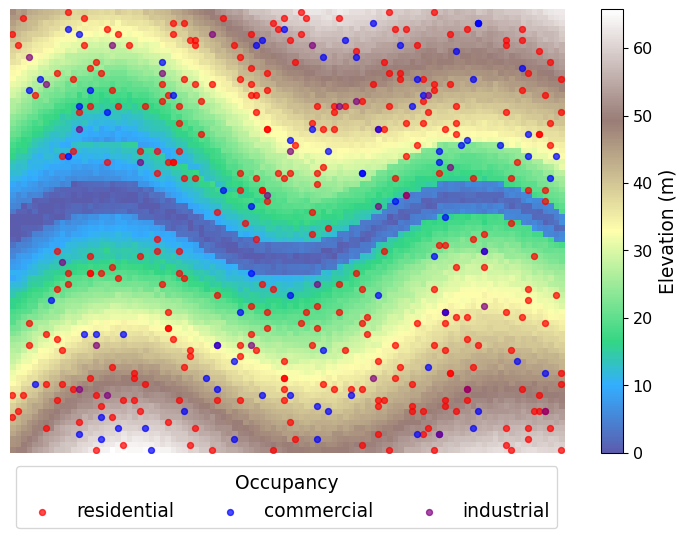

In [3]:
def generate_building_inventory(terrain, n_buildings=500, min_elevation=10):
    """
    Creates building inventory, excluding buildings in flood-prone areas.
    
    Generate buildings randomly, then filter out those 
    below minimum elevation.

    Keyword arguments:
    terrain -- digital elevation grid
    n_buildings -- the max number of buildings in the city
    min_elevation -- the lowest elevation a building can have
    """
    # Set seed for reproducible inventory
    rng = np.random.default_rng(42)

    # Keep track of grid dimensions
    height, width = terrain.shape
    
    # Vectorized location sampling
    x_coords = rng.integers(0, width, n_buildings)
    y_coords = rng.integers(0, height, n_buildings)
    
    # Get elevations using numpy indexing
    elevations = terrain[y_coords, x_coords]
    
    # Keep only buildings above minimum elevation
    # This automatically excludes buildings in the river, and some near
    valid_mask = elevations > min_elevation
    
    # Apply filter to all arrays
    x_coords = x_coords[valid_mask]
    y_coords = y_coords[valid_mask]
    elevations = elevations[valid_mask]
    
    # Check how many buildingds we're left with
    n_actual = len(x_coords)
    
    # Generate building characteristics (vectorized)
    building_types = rng.choice(
        ['residential', 'commercial', 'industrial'],
        size=n_actual,
        p=[0.75, 0.2, 0.05]
    )
    
    # Structure values by type (vectorized with masks)
    values = np.zeros(n_actual)
    residential_mask = (building_types == 'residential')
    commercial_mask = (building_types == 'commercial')
    industrial_mask = (building_types == 'industrial')
    
    values[residential_mask] = rng.lognormal(12, 0.5, residential_mask.sum())
    values[commercial_mask] = rng.lognormal(13, 0.7, commercial_mask.sum())
    values[industrial_mask] = rng.lognormal(14, 0.8, industrial_mask.sum())

    # Create DataFrame
    buildings = pd.DataFrame({
        'bld_id': [f'{i:04d}' for i in range(n_actual)],
        'x': x_coords,
        'y': y_coords,
        'elevation': elevations,
        'type': building_types,
        'value': values
    })
    
    return buildings

# Generate building inventory
buildings = generate_building_inventory(terrain, n_buildings=500, min_elevation=10)


# Visualize building locations on terrain
fig, ax = plt.subplots(figsize=(10, 6))

# Show terrain
img = ax.imshow(terrain, cmap='terrain', origin='lower', alpha=0.8)
cbar = plt.colorbar(img)
cbar.set_label('Elevation (m)', size=14, rotation=90)
cbar.ax.tick_params(labelsize=12)

# Add building locations colored by type
colors = {'residential': 'red', 'commercial': 'blue', 'industrial': 'purple'}
for building_type, color in colors.items():
    type_buildings = buildings[buildings['type'] == building_type]
    ax.scatter(type_buildings['x'], type_buildings['y'], 
               c=color, s=20, alpha=0.7, label=building_type)

ax.legend(bbox_to_anchor=(.5, -.1),
          loc='center',
          ncols=3,
          fontsize=14,
          title_fontsize=14,
          title='Occupancy')
ax.axis('off')
plt.show()

Now we’ll generate two flood scenarios. We’ll organize our
parameterizations for each scenario using dictionaries. Then we’ll
simulate the floods in a highly stylized fashion to get depth grids.

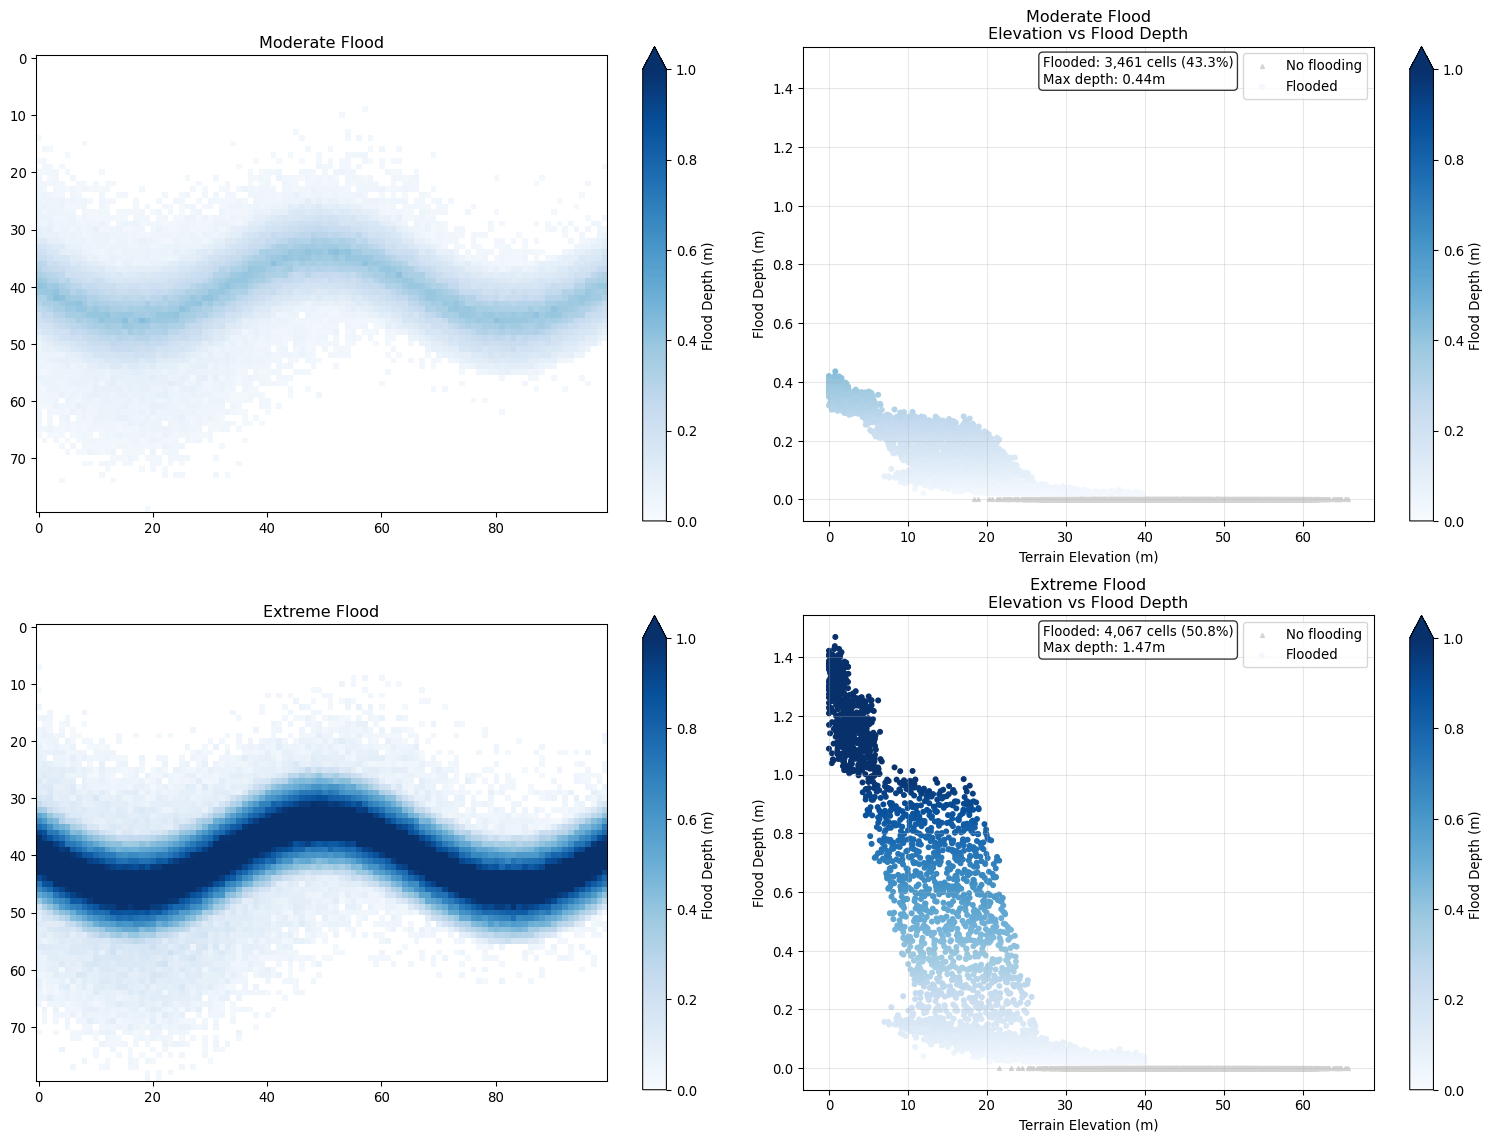

In [4]:
scenarios = {
        'moderate': {
            'name': 'Moderate Flood',
            'rainfall_mm': 100,
            'river_discharge_multiplier': 3.0,
            'storm_duration_hours': 12
        },
        'extreme': {
            'name': 'Extreme Flood', 
            'rainfall_mm': 200,
            'river_discharge_multiplier': 6.0,
            'storm_duration_hours': 24
        }
    }

def simulate_flood(terrain, river_distance, scenario_params):
    """
    Simple linear flood model based on terrain characteristics.
    
    Flood depth depends on:
    - Base scenario intensity
    - Distance to river (closer = more flooding)
    - Elevation (lower = more flooding)
    - Random noise (varies by distance to river)

    Keyword arguments:
    terrain -- digital elevation grid
    river_distance -- grid of distances from river
    scenario_params -- dict of flood scenario details
    """
    # Random seed for reproducibility
    rng = np.random.default_rng(42)

    # Base flood intensity from scenario
    base_intensity = scenario_params['rainfall_mm'] / 1000  # Convert to meters
    river_intensity = base_intensity * scenario_params['river_discharge_multiplier']
    
    # Linear model for flood depth
    # Flood depth = base + river_effect + elevation_effect + noise
    
    # River effect: flooding decreases with distance from river
    river_effect = np.maximum(0, river_intensity * (10 - river_distance) / 10)
    
    # Elevation effect: flooding decreases with elevation above minimum
    min_elevation = np.min(terrain)
    elevation_effect = np.maximum(0, base_intensity * (35 - (terrain - min_elevation)) / 35)
    
    # Spatially varying noise
    # More variability near river (complex hydrology)
    # Less variability on uplands (simple runoff)
    noise_scale = 0.1 * base_intensity * (1 + 0.5 / (1 + river_distance))
    noise = rng.normal(0, noise_scale, terrain.shape)
    
    # Combine effects
    flood_depth = river_effect + elevation_effect + noise
    
    # Ensure realistic constraints
    # No negative depths
    flood_depth = np.maximum(flood_depth, 0)
    
    # Cap maximum depth (physical limit)
    flood_depth = np.minimum(flood_depth, 5.0)
    
    # Areas above certain elevation rarely flood
    high_elevation_mask = terrain > (min_elevation + 40)
    flood_depth[high_elevation_mask] *= 0.1  # Reduce flooding on high ground
    
    # Very small depths set to zero (not meaningful flooding)
    flood_depth[flood_depth < 0.02] = 0
    
    return flood_depth

# Run the simplified simulations
flood_results = {}

for scenario_id, params in scenarios.items():
    flood_depth = simulate_flood(terrain, river_distance, params)
    flood_results[scenario_id] = {
        'depth': flood_depth,
        'params': params,
        'flooded_cells': np.sum(flood_depth > 0.01),  # 1cm threshold
        'max_depth': np.max(flood_depth),
        'mean_depth': np.mean(flood_depth[flood_depth > 0.01]) if np.any(flood_depth > 0.01) else 0
    }

# Enhanced visualization with proper handling of zero flood depths
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey='col')

for i, (scenario_id, results) in enumerate(flood_results.items()):
    row = i
    
    # Only show flood depths, gray for no flooding
    flood_depth_viz = results['depth'].copy()
    
    # Create a masked array where zeros are masked
    flood_depth_masked = np.ma.masked_where(flood_depth_viz <= 0.01, flood_depth_viz)
    
    # Show only flood depths (zeros will be transparent, showing gray background)
    im = axes[row, 0].imshow(flood_depth_masked, cmap='Blues', vmin=0, vmax=1)
    
    axes[row, 0].set_title(f"{results['params']['name']}")
    
    # Add colorbar with proper label
    cbar = plt.colorbar(im, ax=axes[row, 0], extend='max', label='Flood Depth (m)')
    
    # Show flooded and non-flooded areas
    # Get all terrain elevations
    all_elevations = terrain.flatten()
    all_flood_depths = results['depth'].flatten()
    
    # Separate flooded and non-flooded areas
    flooded_mask = all_flood_depths > 0.01
    non_flooded_mask = all_flood_depths <= 0.01
    
    # Plot non-flooded areas (gray triangles)
    if np.any(non_flooded_mask):
        axes[row, 1].scatter(all_elevations[non_flooded_mask], 
                           all_flood_depths[non_flooded_mask],
                           c='lightgray', marker='^', s=8, alpha=1, 
                           label='No flooding')
    
    # Plot flooded areas (blue circles)
    if np.any(flooded_mask):
        scatter = axes[row, 1].scatter(all_elevations[flooded_mask], 
                                     all_flood_depths[flooded_mask],
                                     c=all_flood_depths[flooded_mask], 
                                     cmap='Blues', s=12, alpha=1,
                                     vmin=0, vmax=1,
                                     label='Flooded')
        
        # Add colorbar for scatter plot
        plt.colorbar(scatter, ax=axes[row, 1], extend='max', label='Flood Depth (m)')
    
    axes[row, 1].set_xlabel('Terrain Elevation (m)')
    axes[row, 1].set_ylabel('Flood Depth (m)')
    axes[row, 1].set_title(f"{results['params']['name']}\nElevation vs Flood Depth")
    axes[row, 1].grid(True, alpha=0.3)
    axes[row, 1].legend()
    
    # Add some summary statistics as text
    flooded_cells = np.sum(flooded_mask)
    total_cells = len(all_elevations)
    flood_percentage = (flooded_cells / total_cells) * 100
       
    # Add text box with statistics
    stats_text = f'Flooded: {flooded_cells:,} cells ({flood_percentage:.1f}%)\n'
    stats_text += f'Max depth: {results["max_depth"]:.2f}m'
    axes[row, 1].text(0.42, 0.98, stats_text, transform=axes[row, 1].transAxes, 
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Analyzing risk

Now it’s time to calculate flood damages. We will identify which
buildings face flooding in each scenario, then will apply (made up)
depth-damage functions to translate exposure into damages. These
functions return damage as a fraction of building value, so we will
scale these outputs by each building’s value.

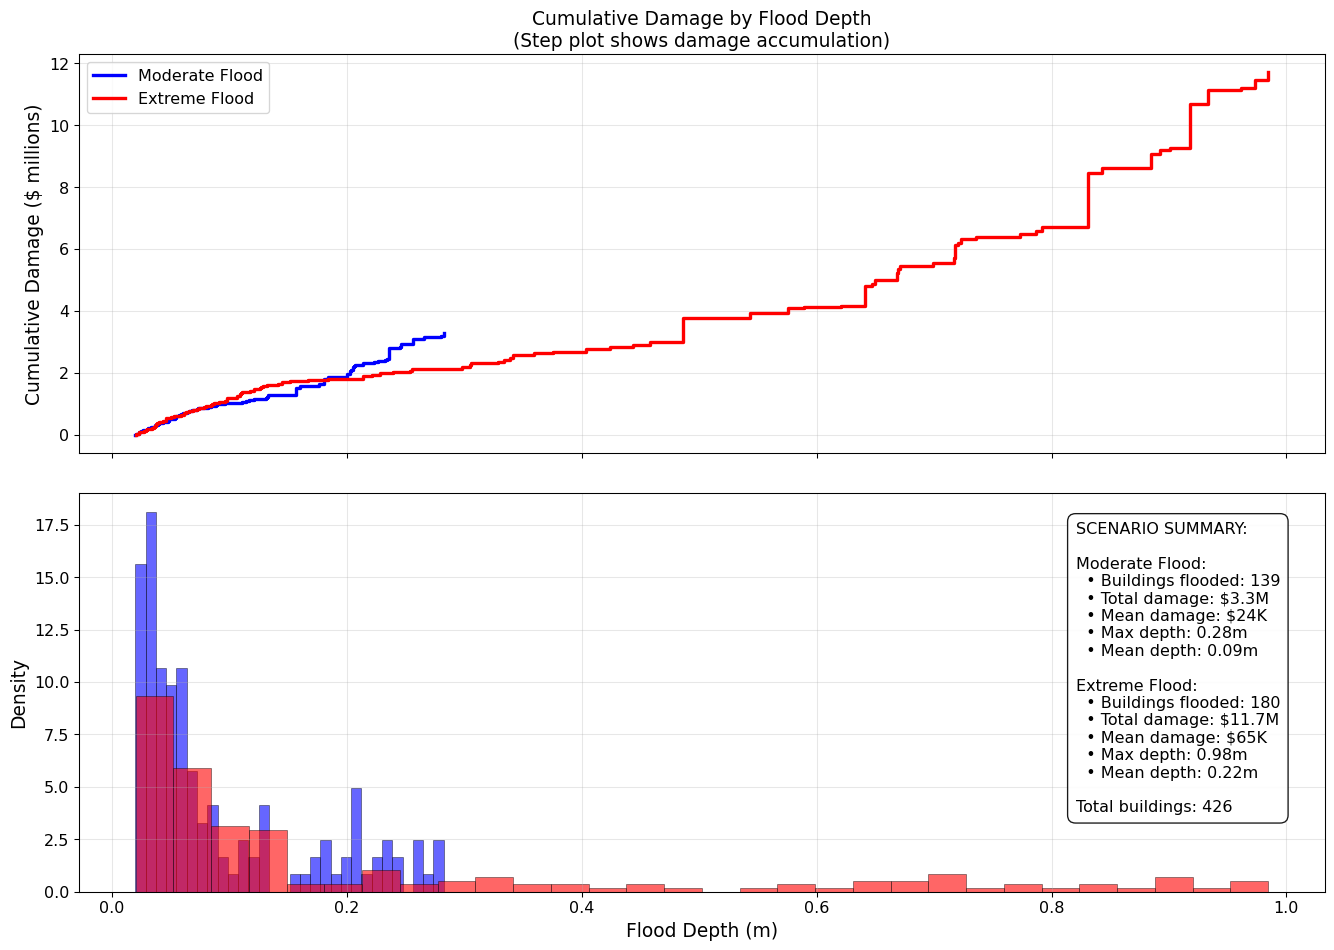

In [5]:
# Get building depths for each scenario
for scenario_id, results in flood_results.items():
    depths = results['depth'][buildings['y'], buildings['x']]
    buildings['depth_{}'.format(scenario_id)] = pd.Series(depths)

# Function for estimating damages
def calc_flood_damages(buildings, depth_col):
    """
    Estimate flood damages for the merged flood scenarios

    Keyword arguments:
    buildings -- our building inventory
    depth_cols -- name of the flood scenario to calculate damages

    Note: we must have preprocessed depth columns in the buildings dataframe
    to avoid throwing an Error (it's much better to explicitly handle this if you can!)
    """

    # Set seed for reproducibility
    rng = np.random.default_rng(42)

    # Helpful to have a function for the depth-damage curves
    def damage_curve_deterministic(depth, building_type):
        """
        Base damage curves without noise - cleaner for teaching the core concept.
        """
        if depth <= 0.01: 
            return 0
        elif depth <= 0.25:  
            if building_type == 'residential':
                return 0.1 + 0.3 * (depth - 0.1) / 0.4
            else:
                return 0.05 + 0.2 * (depth - 0.1) / 0.4
        elif depth <= .75:  
            if building_type == 'residential':
                return 0.4 + 0.3 * (depth - 0.5) / 0.5
            else:
                return 0.25 + 0.4 * (depth - 0.5) / 0.5
        else:  
            if building_type == 'residential':
                return min(0.7 + 0.2 * (depth - 1.0), 0.95)
            else:
                return min(0.65 + 0.25 * (depth - 1.0), 0.90)
    
    # Calculate deterministic damage ratios using vectorized pandas apply
    damage_ratios_base = buildings.apply(
        lambda row: damage_curve_deterministic(row[depth_col], row['type']), 
        axis=1
    )

    # Add noise
    # Uncertainty increases with predicted damage level
    # Low damage = low uncertainty, High damage = high uncertainty
    # Create noise scale that increases with predicted damage
    # No noise for zero damage, maximum noise for high damage
    noise_scale = 0.15 * damage_ratios_base  # 15% relative noise
        
    # Generate heteroskedastic noise
    damage_noise = rng.normal(0, noise_scale)
    
    # Apply noise to damage ratios
    damage_ratios_noisy = damage_ratios_base + damage_noise
    
    # Ensure realistic bounds (damage ratios must be between 0 and 1)
    damage_ratios_final = np.clip(damage_ratios_noisy, 0, 1)
        
    # Return damage amounts
    return buildings['value'] * damage_ratios_final

# Calculate damages
# Identify depth columns and loop through them
# Store the scenario name to create the damage column

# This is called list comprehension - very handy!
depth_cols = [x for x in buildings.columns if 'depth' in x]
# Our names of interest come after a '_' so we can split our strings
for d_col in depth_cols:
    # This returns a list of strings after splitting on '_'
    # and we want the last indexed string in that list
    scenario = d_col.split('_')[-1]
    dam_col = 'damage_{}'.format(scenario)
    damage = calc_flood_damages(buildings, d_col)
    buildings[dam_col] = damage


## Diagnostic plot
fig, (ax1, ax2) = plt.subplots(2, 1,
                               sharex=True,
                               figsize=(14, 10))
    
# Define colors and scenario info
scenarios_plot = {
    'moderate_flood': {
        'color': 'blue',
        'label': 'Moderate Flood',
        'depth_col': 'depth_moderate',
        'damage_col': 'damage_moderate'
    },
    'extreme_flood': {
        'color': 'red', 
        'label': 'Extreme Flood',
        'depth_col': 'depth_extreme',
        'damage_col': 'damage_extreme'
    }
}

min_dam_depth = .01

# Cumulative damage curves
for scenario_id, info in scenarios_plot.items():
    # Filter to buildings with flooding in this scenario
    flooded_buildings = buildings[
        buildings[info['depth_col']] > min_dam_depth
    ].copy()
    
    if len(flooded_buildings) > 0:
        # Sort by flood depth
        flooded_buildings = flooded_buildings.sort_values(info['depth_col'])
        
        # Calculate cumulative damage
        cumulative_damage = flooded_buildings[info['damage_col']].cumsum()
        flood_depths = flooded_buildings[info['depth_col']]
        
        # Create step plot
        ax1.step(flood_depths, cumulative_damage / 1e6, 
                where='post', linewidth=2.5, 
                color=info['color'], label=info['label'])
        
ax1.set_ylabel('Cumulative Damage ($ millions)', size=14)
ax1.set_title('Cumulative Damage by Flood Depth\n(Step plot shows damage accumulation)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

# Overlapping histograms of flood depths
for scenario_id, info in scenarios_plot.items():
    flood_depths = buildings[info['depth_col']]
    flooded_depths = flood_depths[flood_depths > min_dam_depth]
    
    if len(flooded_depths) > 0:
        ax2.hist(flooded_depths, bins=30, alpha=0.6, 
                color=info['color'], label=info['label'],
                edgecolor='black', linewidth=0.5, density=True)

ax2.set_xlabel('Flood Depth (m)', size=14)
ax2.set_ylabel('Density', size=14)
ax2.grid(True, alpha=0.3)

# Add summary statistics as text annotations
summary_text = "SCENARIO SUMMARY:\n\n"

for scenario_id, info in scenarios_plot.items():
    flood_depths = buildings[info['depth_col']]
    damages = buildings[info['damage_col']]
    
    # Calculate statistics
    n_flooded = np.sum(flood_depths > min_dam_depth)
    total_damage = damages.sum()
    mean_damage = damages[damages > 0].mean() if np.any(damages > 0) else 0
    max_depth = flood_depths.max()
    mean_depth = flood_depths[flood_depths > min_dam_depth].mean() if np.any(flood_depths > min_dam_depth) else 0
    
    summary_text += f"{info['label']}:\n"
    summary_text += f"  • Buildings flooded: {n_flooded:,}\n"
    summary_text += f"  • Total damage: ${total_damage/1e6:.1f}M\n"
    summary_text += f"  • Mean damage: ${mean_damage/1e3:.0f}K\n"
    summary_text += f"  • Max depth: {max_depth:.2f}m\n"
    summary_text += f"  • Mean depth: {mean_depth:.2f}m\n\n"

# Add text box with statistics
summary_text += f"Total buildings: {len(buildings)}"
ax2.text(0.8, 0.2, summary_text, transform=ax2.transAxes,
            fontsize=12,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

Now we compare different flood mitigation options. We will make very
rudimentary assumptions about costs and benefits for different actions.
While the text table does not render colors on the website, checkout
what happens in your Jupyter notebook!

In [6]:
def analyze_mitigation_strategies_multi_scenario(buildings):
    """
    Evaluates mitigation strategies across both flood scenarios.
    """
    
    # Calculate baseline damages for both scenarios
    baseline_moderate = buildings['damage_moderate'].sum()
    baseline_extreme = buildings['damage_extreme'].sum()
    
    print(f"Baseline damages:")
    print(f"  Moderate flood: ${baseline_moderate:,.0f}")
    print(f"  Extreme flood: ${baseline_extreme:,.0f}")
    
    # Define mitigation strategies
    strategies = {
        'do_nothing': {
            'cost': 0,
            'damage_reduction_moderate': 0,
            'damage_reduction_extreme': 0,
            'description': 'Accept current flood risk'
        },
        'early_warning': {
            'cost': 500_000,
            'damage_reduction_moderate': 0.15,  # 15% reduction through evacuation
            'damage_reduction_extreme': 0.12,   # Less effective in extreme events
            'description': 'Flood warning system + evacuation plans'
        },
        'levees': {
            'cost': 25_000_000,
            'damage_reduction_moderate': 0.70,  # Very effective for moderate floods
            'damage_reduction_extreme': 0.45,   # Less effective for extreme floods
            'description': 'Construct flood levees along river'
        },
        'buyouts': {
            'cost': 15_000_000,  # Simplified cost
            'damage_reduction_moderate': 0.35,  # Remove highest-risk buildings
            'damage_reduction_extreme': 0.40,   # More effective in extreme events
            'description': 'Buy out highest-risk properties'
        },
        'green_infrastructure': {
            'cost': 12_000_000,
            'damage_reduction_moderate': 0.30,  # Natural storage
            'damage_reduction_extreme': 0.35,   # Better performance in extreme events
            'description': 'Wetland restoration + permeable surfaces'
        },
        'combined_approach': {
            'cost': 18_000_000,
            'damage_reduction_moderate': 0.50,  # Combines multiple strategies
            'damage_reduction_extreme': 0.6,   # Better performance in extremes
            'description': 'Early warning + green infrastructure + targeted buyouts'
        }
    }
    
    # Calculate metrics for each strategy
    strategy_analysis = []
    
    for name, strategy in strategies.items():
        # Calculate avoided damages for both scenarios
        avoided_moderate = baseline_moderate * strategy['damage_reduction_moderate']
        avoided_extreme = baseline_extreme * strategy['damage_reduction_extreme']
        
        # Calculate net benefits
        net_benefit_moderate = avoided_moderate - strategy['cost']
        net_benefit_extreme = avoided_extreme - strategy['cost']

        strategy_analysis.append({
            'strategy': name,
            'description': strategy['description'],
            'cost': strategy['cost'],
            'avoided_damage_moderate': avoided_moderate,
            'avoided_damage_extreme': avoided_extreme,
            'net_benefit_moderate': net_benefit_moderate,
            'net_benefit_extreme': net_benefit_extreme
        })
    
    return pd.DataFrame(strategy_analysis)

# Run the multi-scenario analysis
strategy_results = analyze_mitigation_strategies_multi_scenario(buildings)

# Create a nicely formatted table with colors
def print_strategy_table(strategy_df):
    """
    Pretty print the strategy analysis table with colored output.
    Red for costs, black for benefits.
    """
    
    # ANSI color codes
    RED = '\033[91m'
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
    print(f"\n{BOLD} MITIGATION STRATEGY ANALYSIS - MULTI-SCENARIO{END}")
    print("="*100)
    
    # Table header
    print(f"{BOLD}{'Strategy':<20} {'Cost':<12} {'Avoided Damage':<25} {'Net Benefit':<25}{END}")
    print(f"{BOLD}{'':20} {'($M)':<12} {'Mod/Ext ($M)':<25} {'Mod/Ext ($M)':<25}{END}")
    print("-" * 100)
    
    for idx, row in strategy_df.iterrows():
        strategy_name = row['strategy'].replace('_', ' ').title()
        
        # Format costs (red)
        cost_str = f"{RED}${row['cost']/1e6:.1f}{END}"
        
        # Format avoided damages (green if positive)
        avoided_mod = row['avoided_damage_moderate'] / 1e6
        avoided_ext = row['avoided_damage_extreme'] / 1e6
        avoided_str = f"{GREEN}${avoided_mod:.1f}/${avoided_ext:.1f}{END}"
        
        # Format net benefits (green if positive, red if negative)
        net_mod = row['net_benefit_moderate'] / 1e6
        net_ext = row['net_benefit_extreme'] / 1e6
        
        net_mod_color = GREEN if net_mod > 0 else RED
        net_ext_color = GREEN if net_ext > 0 else RED
        net_str = f"{net_mod_color}${net_mod:.1f}{END}/{net_ext_color}${net_ext:.1f}{END}"
        
        print(f"{strategy_name:<20} {cost_str:<20} {avoided_str:<35} {net_str:<35}")
    
    print("\n" + "="*100)
    print(f"{BOLD}Legend:{END}")
    print(f"  • {GREEN}Green{END} = Positive value (benefit)")
    print(f"  • {RED}Red{END} = Negative value (cost)")
    print(f"  • Mod/Ext = Moderate/Extreme flood scenarios")

# Print the formatted table
print_strategy_table(strategy_results)

Baseline damages:
  Moderate flood: $3,295,652
  Extreme flood: $11,712,878

 MITIGATION STRATEGY ANALYSIS - MULTI-SCENARIO
Strategy             Cost         Avoided Damage            Net Benefit              
                     ($M)         Mod/Ext ($M)              Mod/Ext ($M)             
----------------------------------------------------------------------------------------------------
Do Nothing           $0.0        $0.0/$0.0                  $0.0/$0.0        
Early Warning        $0.5        $0.5/$1.4                  $-0.0/$0.9       
Levees               $25.0       $2.3/$5.3                  $-22.7/$-19.7    
Buyouts              $15.0       $1.2/$4.7                  $-13.8/$-10.3    
Green Infrastructure $12.0       $1.0/$4.1                  $-11.0/$-7.9     
Combined Approach    $18.0       $1.6/$7.0                  $-16.4/$-11.0    

Legend:
  • Green = Positive value (benefit)
  • Red = Negative value (cost)
  • Mod/Ext = Moderate/Extreme flood scenarios

### Wrapping up the analysis

1.  Save your figures in the `figures/` subdirectory (check the
    resolution)
2.  Finalize a comprehensive `.README`
3.  Push final changes to GitHub (hopefully you made commits throughout)
4.  Convert your notebook to pdf and submit on Canvas

**Note:** If you would like to experiment with code, I am happy to
review and provide feedback! For example, you might want to create a new
notebook where you initialize a different terrain and/or flood model,
building representation, etc., You might want to try adding figures to
your main notebook, or flood scenarios. If you want practice and have
some extra time, go for it!